In [1]:
%pip install ultralytics dill opencv-python matplotlib facenet-pytorch mtcnn
# 必要なライブラリを一度にインストールします（ノートブック内で実行）。

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


検出された顔（推定）数: 39


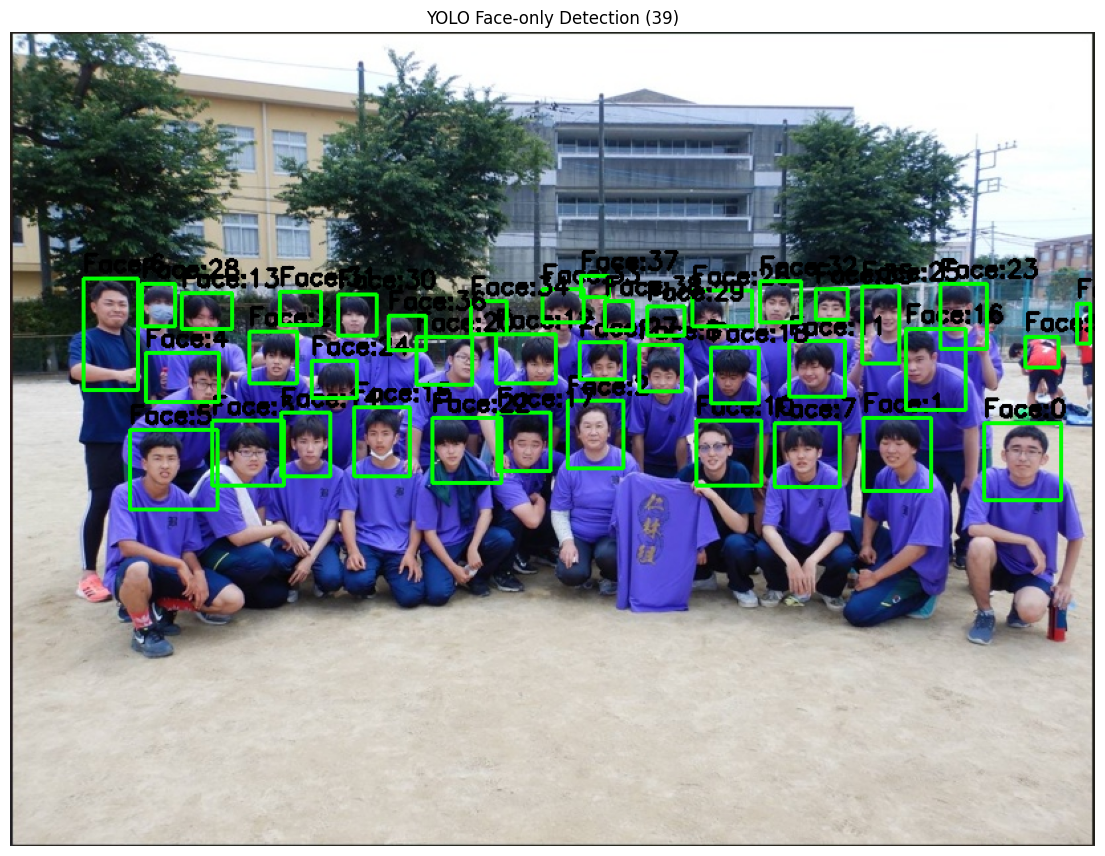

In [7]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# パス
# =========================
image_path = Path("converted_image.jpg")
output_path = Path("yolo_face_only.jpg")

# =========================
# YOLO公式モデル（自動DL）
# =========================
model = YOLO("yolov8n.pt")

# =========================
# 推論
# =========================
results = model.predict(
    source=str(image_path),
    conf=0.3,
    imgsz=1280,
    verbose=False
)

image = cv2.imread(str(image_path))
h_img, w_img = image.shape[:2]

face_id = 0

# =========================
# 「人」→「顔」推定
# =========================
for box, cls in zip(results[0].boxes.xyxy.cpu().numpy(),
                    results[0].boxes.cls.cpu().numpy()):

    # person クラスのみ（COCO: 0）
    if int(cls) != 0:
        continue

    x1, y1, x2, y2 = map(int, box)
    bw = x2 - x1
    bh = y2 - y1

    # ===== 顔は上部35%と仮定 =====
    face_h = int(bh * 0.35)
    fx1 = x1 + int(bw * 0.2)
    fx2 = x2 - int(bw * 0.2)
    fy1 = y1
    fy2 = y1 + face_h

    # 画像外防止
    fx1 = max(0, fx1); fy1 = max(0, fy1)
    fx2 = min(w_img, fx2); fy2 = min(h_img, fy2)

    # 枠描画（顔のみ）
    cv2.rectangle(image, (fx1, fy1), (fx2, fy2), (0, 255, 0), 2)
    cv2.putText(
        image, f"Face:{face_id}",
        (fx1, fy1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6, (0, 0, 0), 2
    )

    face_id += 1

# =========================
# 保存・表示
# =========================
cv2.imwrite(str(output_path), image)

print(f"検出された顔（推定）数: {face_id}")

plt.figure(figsize=(14, 14))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"YOLO Face-only Detection ({face_id})")
plt.show()


In [20]:
replace_path = Path("Generated_.png")


置換した顔の数: 39
保存先: face_replaced.jpg


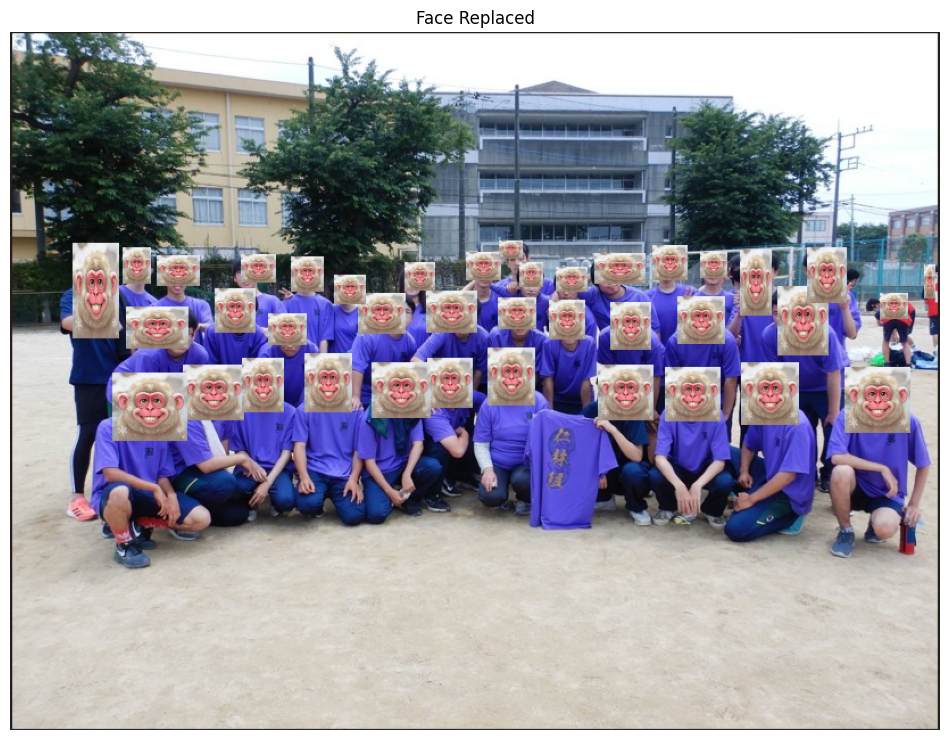

In [27]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# =========================
# パス設定
# =========================
image_path = Path("converted_image.jpg")     # 元画像
replace_path = Path("Generated_.png")         # 置き換え画像
output_path = Path("face_replaced.jpg")

# =========================
# ファイルチェック
# =========================
for p in [image_path, replace_path]:
    if not p.exists():
        raise FileNotFoundError(f"{p} が見つかりません")

# =========================
# 画像読み込み（安全）
# =========================
image = cv2.imread(str(image_path))
if image is None:
    raise RuntimeError("元画像の読み込みに失敗しました")

h_img, w_img = image.shape[:2]
out = image.copy()

replace_img = cv2.imread(str(replace_path), cv2.IMREAD_UNCHANGED)
if replace_img is None:
    raise RuntimeError("置換画像の読み込みに失敗しました")

# チャンネル補正（RGB化）
if replace_img.ndim == 2:
    replace_img = cv2.cvtColor(replace_img, cv2.COLOR_GRAY2BGR)

# =========================
# YOLO（人物検出）
# =========================
model = YOLO("yolov8n.pt")  # 自動DL

results = model.predict(
    source=str(image_path),
    conf=0.3,
    imgsz=1280,
    verbose=False
)

# 検出0件対策
if results[0].boxes is None or len(results[0].boxes) == 0:
    print("⚠ 人物が検出されませんでした。処理をスキップします。")

else:
    face_id = 0

    for box, cls in zip(
        results[0].boxes.xyxy.cpu().numpy(),
        results[0].boxes.cls.cpu().numpy()
    ):
        # COCO: person = 0
        if int(cls) != 0:
            continue

        x1, y1, x2, y2 = map(int, box)
        bw = x2 - x1
        bh = y2 - y1

        # 顔領域（上部35%）
        face_h = int(bh * 0.35)
        fx1 = x1 + int(bw * 0.2)
        fx2 = x2 - int(bw * 0.2)
        fy1 = y1
        fy2 = y1 + face_h

        # 画像外防止
        fx1 = max(0, fx1); fy1 = max(0, fy1)
        fx2 = min(w_img, fx2); fy2 = min(h_img, fy2)

        fw = fx2 - fx1
        fh = fy2 - fy1
        if fw <= 0 or fh <= 0:
            continue

        # =========================
        # 置換
        # =========================
        repl = cv2.resize(replace_img, (fw, fh), interpolation=cv2.INTER_AREA)

        if repl.shape[2] == 4:
            alpha = repl[:, :, 3] / 255.0
            for c in range(3):
                out[fy1:fy2, fx1:fx2, c] = (
                    alpha * repl[:, :, c] +
                    (1 - alpha) * out[fy1:fy2, fx1:fx2, c]
                )
        else:
            out[fy1:fy2, fx1:fx2] = repl[:, :, :3]

        face_id += 1

    print(f"置換した顔の数: {face_id}")

# =========================
# 保存・表示
# =========================
cv2.imwrite(str(output_path), out)
print(f"保存先: {output_path}")

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Face Replaced")
plt.show()